# Normalizing Image Function for LEGO MiniFigure

Function to normalize each of the image based on file path given by the metadata

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tv
import torch
import pandas as pd
import skimage
from skimage import io, transform

## Starting with an example to get a better idea of how to write the function

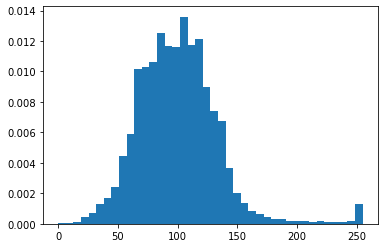

In [2]:
path = "marvel/0001/001.jpg"
img = Image.open(path)

#Converts image to a numpy array
img_nparr = np.array(img)
test = io.imread(path)
#Creating histogram
in_hist = plt.hist(test.ravel(), bins = 40, density = True)

### Convert PIL image to PyTorch Tensor image

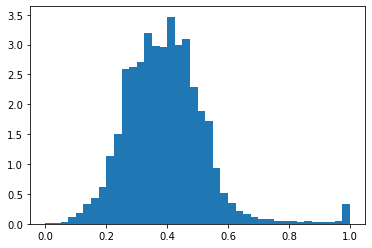

In [3]:
#Tensor transformation
transform1 = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

#Putting image into function
tensor_img = transform1(img)
tensor_img_nparr = np.array(tensor_img)

#Another histogram
tensor_in_hist = plt.hist(tensor_img_nparr.ravel(), bins = 40, density = True)

In [4]:
#Finding mean and std of dataset
std, mean = torch.std_mean(tensor_img,[1,2])
print("Before normalizing --> Mean: " + str(mean) + " | STD: " + str(std))

Before normalizing --> Mean: tensor([0.4404, 0.3913, 0.3464]) | STD: tensor([0.1444, 0.1116, 0.1189])


### Normalizing based on mean/std

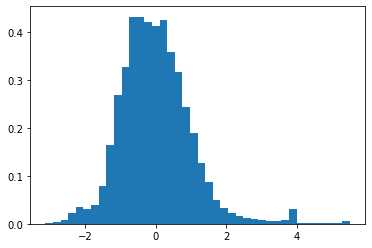

In [5]:
#Creating another transform func
transform1_norm = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean,std)
])

#Transforming image to normalized tensor
norm_img = transform1_norm(img)
norm_img_nparr = np.array(norm_img)

#Yet another histogram
tensor_in_hist = plt.hist(norm_img_nparr.ravel(), bins = 40, density = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 2.1653e-08,  1.2387e-07, -1.1967e-07]) tensor([1., 1., 1.])


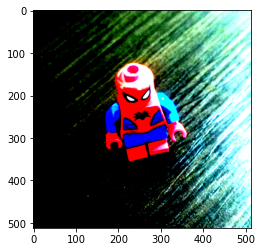

In [6]:
norm_img_view = norm_img_nparr.transpose(1,2,0)
plt.imshow(norm_img_view)

mean, std = norm_img.mean([1,2]), norm_img.std([1,2])
print(mean,std)

# Applying Above to Functions

df = pd.read_csv('data_all.csv')
df = df.drop(['Unnamed: 0','tmp_name','class_id'], axis = 1)

def show_image(path):
    img = Image.open(path)
    plt.imshow(img)
    
df.head()

In [7]:
#Convert the csv into a torch dataset
class LEGODataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, img_size, transform=None):
        
        self.df = pd.read_csv(csv_file)
        #Dropping unnecessary columns
        self.df = self.df.drop(['Unnamed: 0','tmp_name','minifigure_name'], axis = 1)
        self.root_dir = root_dir
        #Added Image Size
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = io.imread(row['path'])
        #Simple code to resize image bruh
        img = skimage.transform.resize(img, self.img_size, anti_aliasing=True)
        #Added y to dict to showcase output labels
        #We're doing class_id - 1 because we want the output to be from 0 to N
        y = torch.tensor(row['class_id']-1, dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
            
        
        sample = {'image': img, 'id_min_1': y}
        #Returns as dict
        return sample
    
norm_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    #VERSATILE MEAN/STD FROM IMAGENET
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

#CHANGE ACCORDINGLY (ROOTDIR)
torch_lego = LEGODataSet(csv_file = 'data_all.csv',
                         root_dir = '/Users/danieltohti/Box Sync/Launch/Week 3 Project/NeuralNet_Project/Images',
                         #img_size being used here
                         img_size = (256,256),
                         transform = norm_transform)

#Dataloader stuff
dataloader = torch.utils.data.DataLoader(torch_lego,
                                         batch_size = 4,
                                         shuffle = True)



#For loop to normalize all images
for i in range(len(torch_lego)):
    #Gets current image
    curr_img = torch_lego[i]['image']
    norm_img = norm_transform(curr_img)
    norm_img_nparr = np.array(norm_img)
    ### SAVE IMAGES TO DATASET BELOW ###
    view_img = np.array(norm_img).transpose(1,2,0)
    print(curr_img)
    if i==3:
        break
    

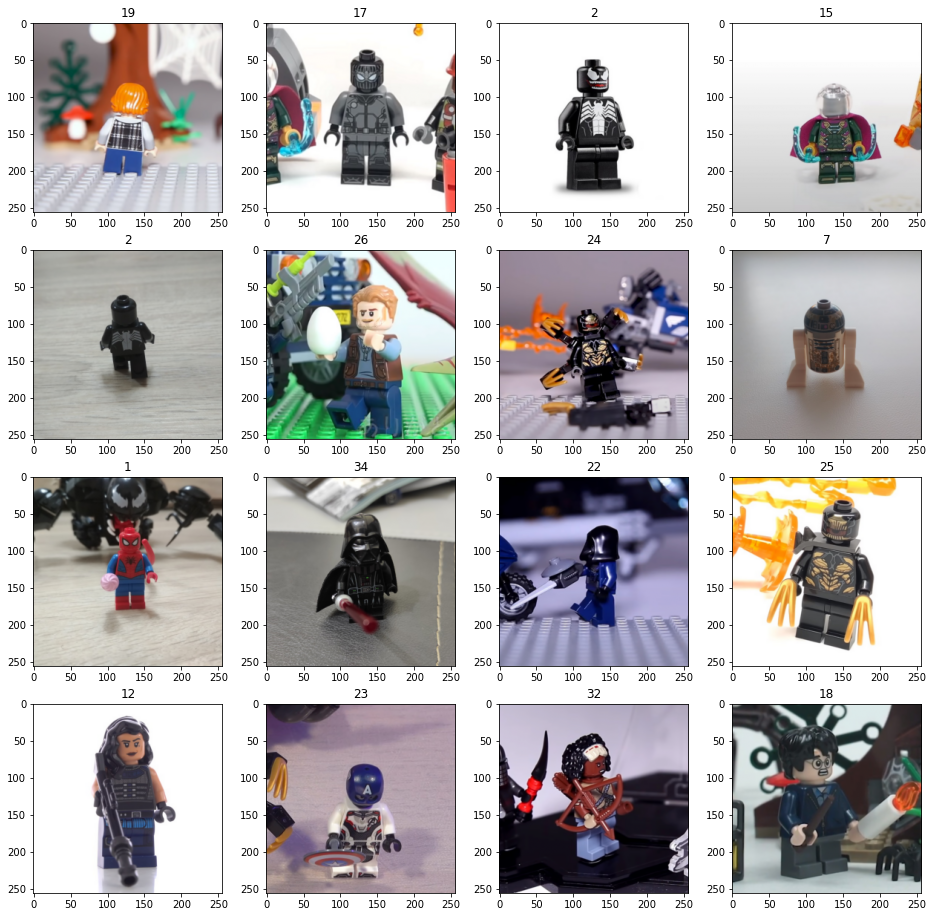

In [8]:

fig = plt.figure(figsize=(16, 16))
#Iterate through the torch dataset with dataloader and enumerate
for i, batch in enumerate(dataloader):
    #Plus one over here to properly match the class_ids
    images, ids = batch['image'], batch['id_min_1']+1
    for j in range(len(images)):
        plt.subplot(4, 4, 4 * i + j + 1)
        norm_view_img = np.array(images[j]).transpose(1,2,0)
        #Just reversing normalization process in below line
        reg_view_img = norm_view_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        #REG_VIEW_IMG shows regular image --> NORM_VIEW_IMG shows normalized image
        plt.imshow(reg_view_img)
        plt.title(ids[j].numpy())
    if i==3:
        break